In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [2]:
BENCHMARKS = {
    'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

def get_all_files(root_folder='../run/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_nested_dict(files):

    data = {}

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            scores = json.load(f)[1]

        if search_space not in data:
            data[search_space] = {}
        if dataset not in data[search_space]:
            data[search_space][dataset] = {}
        if predictor not in data[search_space][dataset]:
            data[search_space][dataset][predictor] = {
                'kendalltau': [],
                'pearson': [],
                'spearman': []
            }
            

        data[search_space][dataset][predictor]['kendalltau'].append(scores['kendalltau'])
        data[search_space][dataset][predictor]['pearson'].append(scores['pearson'])
        data[search_space][dataset][predictor]['spearman'].append(scores['spearman'])
    
    return data

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['predictor', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'predictor')
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['predictor'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['predictor'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        predictors = tuple(df_['predictor'].to_list()) # List of predictor names

#         print('DF IS')
#         print(df_)
        #print(predictors)
        all_corrs.append(compute_correlation(df_, predictors))

#     print('all_corrs ::', np.array(all_corrs).shape)
    corr = np.mean(np.array(all_corrs), axis=0)
#     print('mean corrs ::', corr.shape)
    corr_df = pd.DataFrame(corr)

    predictors_map = {i: predictors[i] for i in range(len(predictors))}
    corr_df = corr_df.rename(columns=predictors_map, index=predictors_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'predictor'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_predictors_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'predictor'])[metric].mean()
    
#     print('pred scores')
#     print(pred_scores)
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            #print(searchspace, dataset)
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

#     print('SERIES')
#     print(series[0])

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
    data = json.load(f)


In [3]:
files = get_all_files()
len(files), files

(275,
 ['../run/correlation/nasbench301/cifar10/fisher/9000/scores.json',
  '../run/correlation/nasbench301/cifar10/fisher/9001/scores.json',
  '../run/correlation/nasbench301/cifar10/fisher/9003/scores.json',
  '../run/correlation/nasbench301/cifar10/fisher/9004/scores.json',
  '../run/correlation/nasbench301/cifar10/fisher/9002/scores.json',
  '../run/correlation/nasbench301/cifar10/grad_norm/9000/scores.json',
  '../run/correlation/nasbench301/cifar10/grad_norm/9001/scores.json',
  '../run/correlation/nasbench301/cifar10/grad_norm/9003/scores.json',
  '../run/correlation/nasbench301/cifar10/grad_norm/9004/scores.json',
  '../run/correlation/nasbench301/cifar10/grad_norm/9002/scores.json',
  '../run/correlation/nasbench301/cifar10/plain/9000/scores.json',
  '../run/correlation/nasbench301/cifar10/plain/9001/scores.json',
  '../run/correlation/nasbench301/cifar10/plain/9003/scores.json',
  '../run/correlation/nasbench301/cifar10/plain/9004/scores.json',
  '../run/correlation/nasbench3

In [4]:
df = make_df(files)
df

,search_space,dataset,predictor,seed,kendalltau,pearson,spearman,preds,ground_truth
0,nasbench301,cifar10,fisher,9000,-0.140704,0.225625,-0.204365,"[0.514511227607727, 0.34462055563926697, 0.312...","[92.894671785109, 94.06732357110496, 91.986789..."
1,nasbench301,cifar10,fisher,9001,-0.143618,0.232857,-0.213469,"[0.4920559823513031, 0.3548348844051361, 0.368...","[92.894671785109, 94.06732357110496, 91.986789..."
2,nasbench301,cifar10,fisher,9003,-0.121106,0.215337,-0.175414,"[0.5997128486633301, 0.4223588705062866, 0.311...","[92.894671785109, 94.06732357110496, 91.986789..."
3,nasbench301,cifar10,fisher,9004,-0.122814,0.202592,-0.183092,"[0.4523699879646301, 0.3048049509525299, 0.297...","[92.894671785109, 94.06732357110496, 91.986789..."
4,nasbench301,cifar10,fisher,9002,-0.160302,0.240341,-0.235075,"[0.47608742117881775, 0.32855209708213806, 0.3...","[92.894671785109, 94.06732357110496, 91.986789..."
...,...,...,...,...,...,...,...,...,...
270,nasbench101,cifar10,l2_norm,9000,0.408198,0.575751,0.572691,"[1224.060791015625, 640.3799438476562, 936.723...","[92.94871687889099, 92.56811141967773, 91.7968..."
271,nasbench101,cifar10,l2_norm,9001,0.328686,0.487624,0.478841,"[1040.9112548828125, 199.47543334960938, 199.4...","[93.85015964508057, 88.5817289352417, 83.46354..."
272,nasbench101,cifar10,l2_norm,9003,0.322491,0.397143,0.461122,"[637.67431640625, 498.68670654296875, 694.6942...","[89.5432710647583, 92.92868375778198, 82.55208..."
273,nasbench101,cifar10,l2_norm,9004,0.407718,0.606317,0.594599,"[741.233154296875, 1226.6573486328125, 1086.04...","[92.71835088729858, 92.90865659713745, 91.9471..."


In [5]:
# Sanity check to see all the seeds are there for all the predictors
show_seeds(df, 'nasbench201')

unique
search_space dataset        predictor                                
nasbench201  ImageNet16-120 epe_nas    [9000, 9001, 9003, 9004, 9002]
                            fisher     [9000, 9001, 9003, 9004, 9002]
                            flops      [9000, 9001, 9003, 9004, 9002]
                            grad_norm  [9000, 9001, 9003, 9004, 9002]
                            grasp      [9000, 9001, 9003, 9004, 9002]
                            jacov      [9000, 9001, 9003, 9004, 9002]
                            l2_norm    [9000, 9001, 9003, 9004, 9002]
                            params     [9000, 9001, 9003, 9004, 9002]
                            plain      [9000, 9001, 9003, 9004, 9002]
                            snip       [9000, 9001, 9003, 9004, 9002]
                            synflow    [9000, 9001, 9003, 9004, 9002]
             cifar10        epe_nas    [9000, 9001, 9003, 9004, 9002]
                            fisher     [9000, 9001, 9003, 9004, 9002]
                            flops      [9000, 9001, 9003, 9004, 9002]
                            grad_norm  [9000, 9001, 9003, 9004, 9002]
                            grasp      [9000, 9001, 9003, 9004, 9002]
                            jacov      [9000, 9001, 9003, 9004, 9002]
                            l2_norm    [9000, 9001, 9003, 9004, 9002]
                            params     [9000, 9001, 9003, 9004, 9002]
                            plain      [9000, 9001, 9003, 9004, 9002]
                            snip       [9000, 9001, 9003, 9004, 9002]
                            synflow    [9000, 9001, 9003, 9004, 9002]
             cifar100       epe_nas    [9000, 9001, 9003, 9004, 9002]
                            fisher     [9000, 9001, 9003, 9004, 9002]
                            flops      [9000, 9001, 9003, 9004, 9002]
                            grad_norm  [9000, 9001, 9003, 9004, 9002]
                            grasp      [9000, 9001, 9003, 9004, 9002]
                            jacov      [9000, 9001, 9003, 9004, 9002]
                            l2_norm    [9000, 9001, 9003, 9004, 9002]
                            params     [9000, 9001, 9003, 9004, 9002]
                            plain      [9000, 9001, 9003, 9004, 9002]
                            snip       [9000, 9001, 9003, 9004, 9002]
                            synflow    [9000, 9001, 9003, 9004, 9002]

,NB101-CF10,NB201-CF10,NB201-CF100,NB201-IMGNT,NB301-CF10
predictor,,,,,
epe_nas,-0.167248,0.732338,0.669535,0.171888,-0.031986
fisher,0.320865,0.488001,0.548222,0.507953,-0.202283
flops,0.762790,0.684498,0.697592,0.672032,0.470275
grad_norm,0.347525,0.588133,0.646729,0.598537,0.029908
grasp,-0.047845,0.443885,0.535056,0.491962,0.260020
jacov,-0.516892,0.738095,0.733282,0.725324,0.059709
l2_norm,0.536599,0.665266,0.702917,0.693290,0.537479
params,0.754615,0.710325,0.719441,0.692872,0.524127
plain,-0.029890,-0.316523,-0.276030,-0.288999,-0.228988


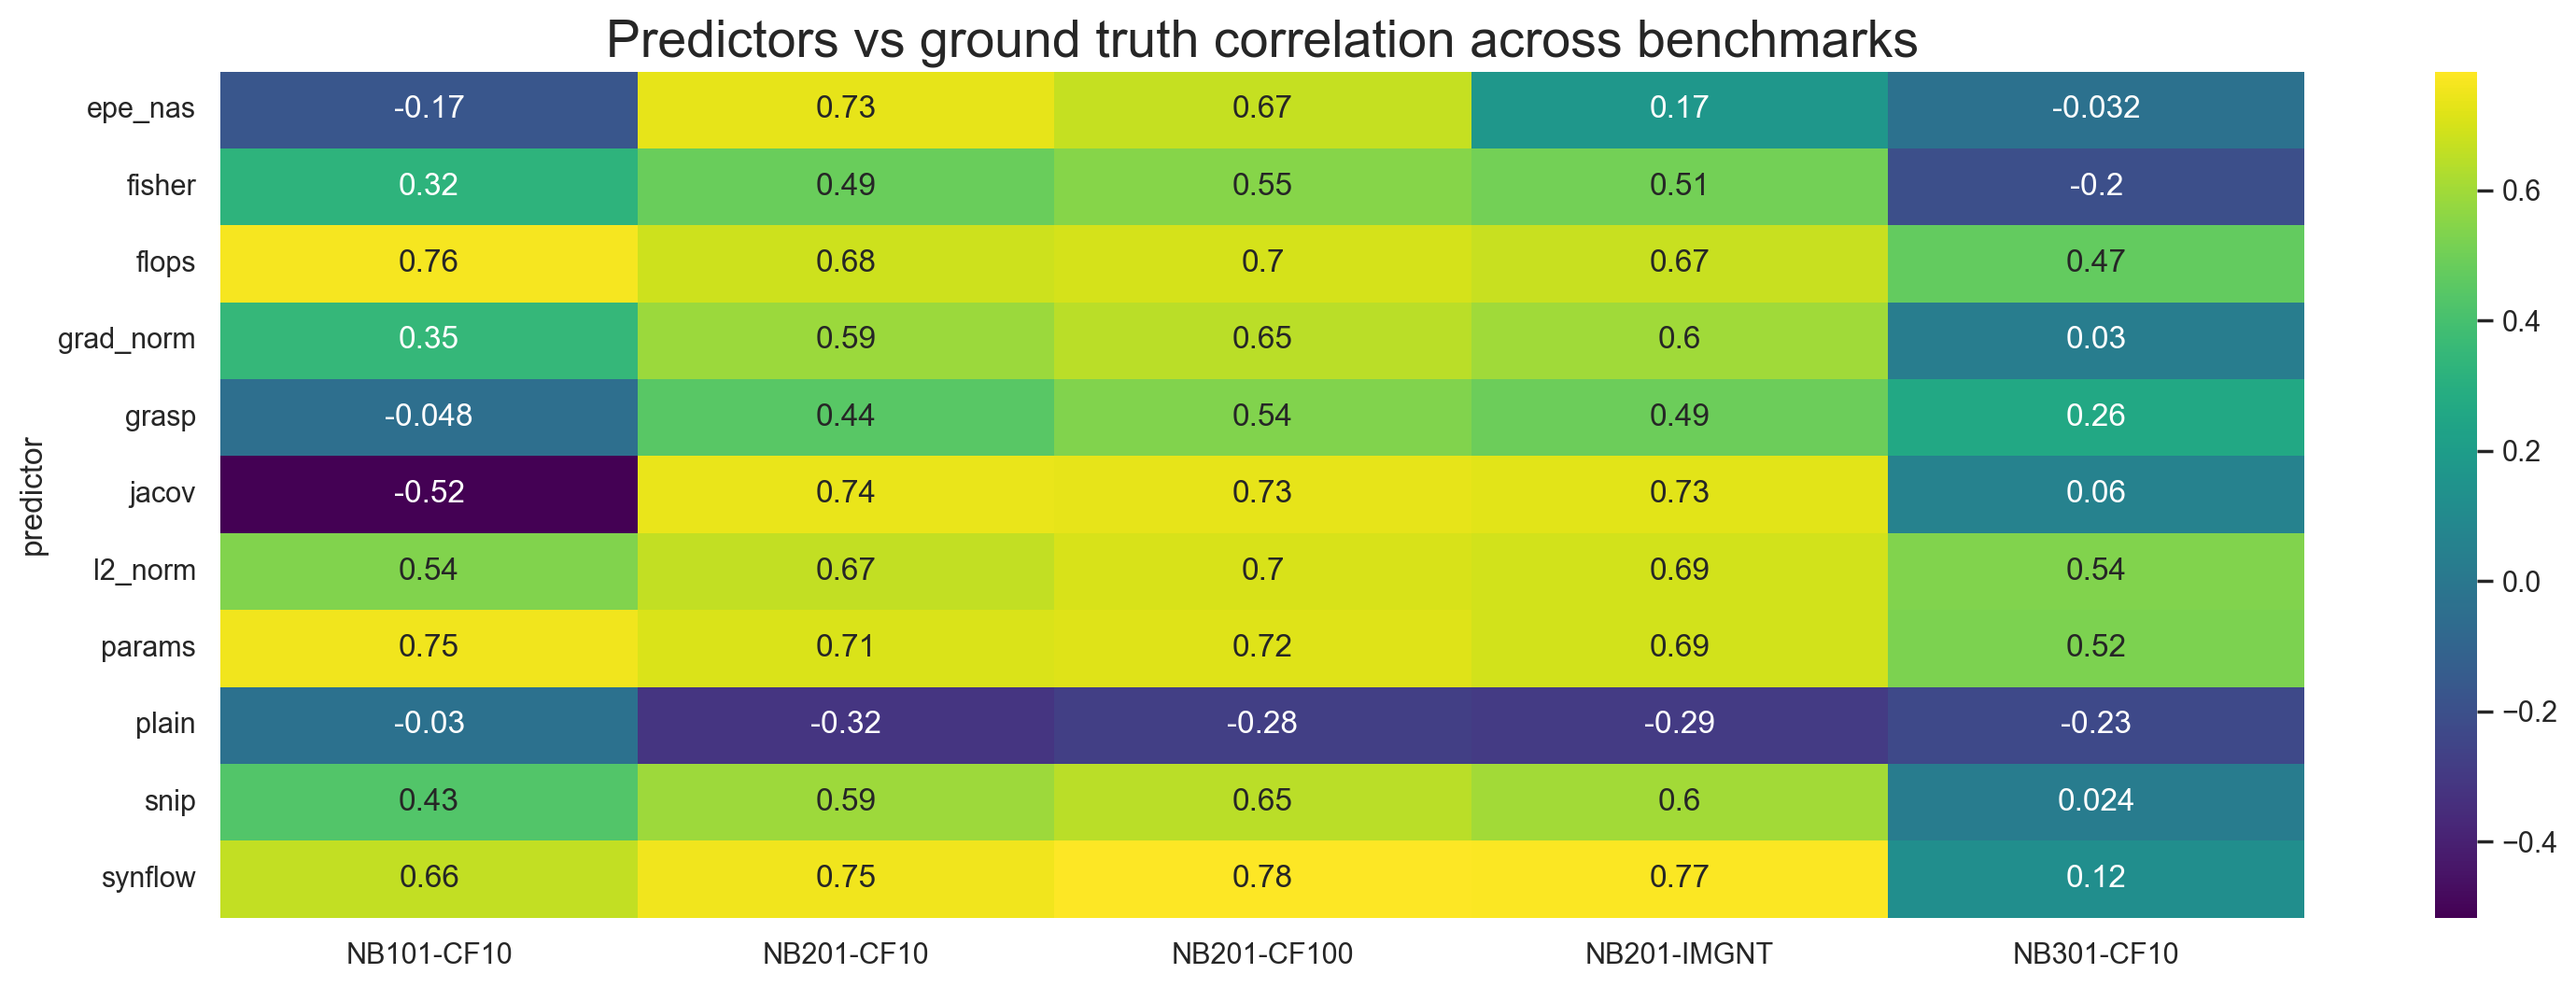

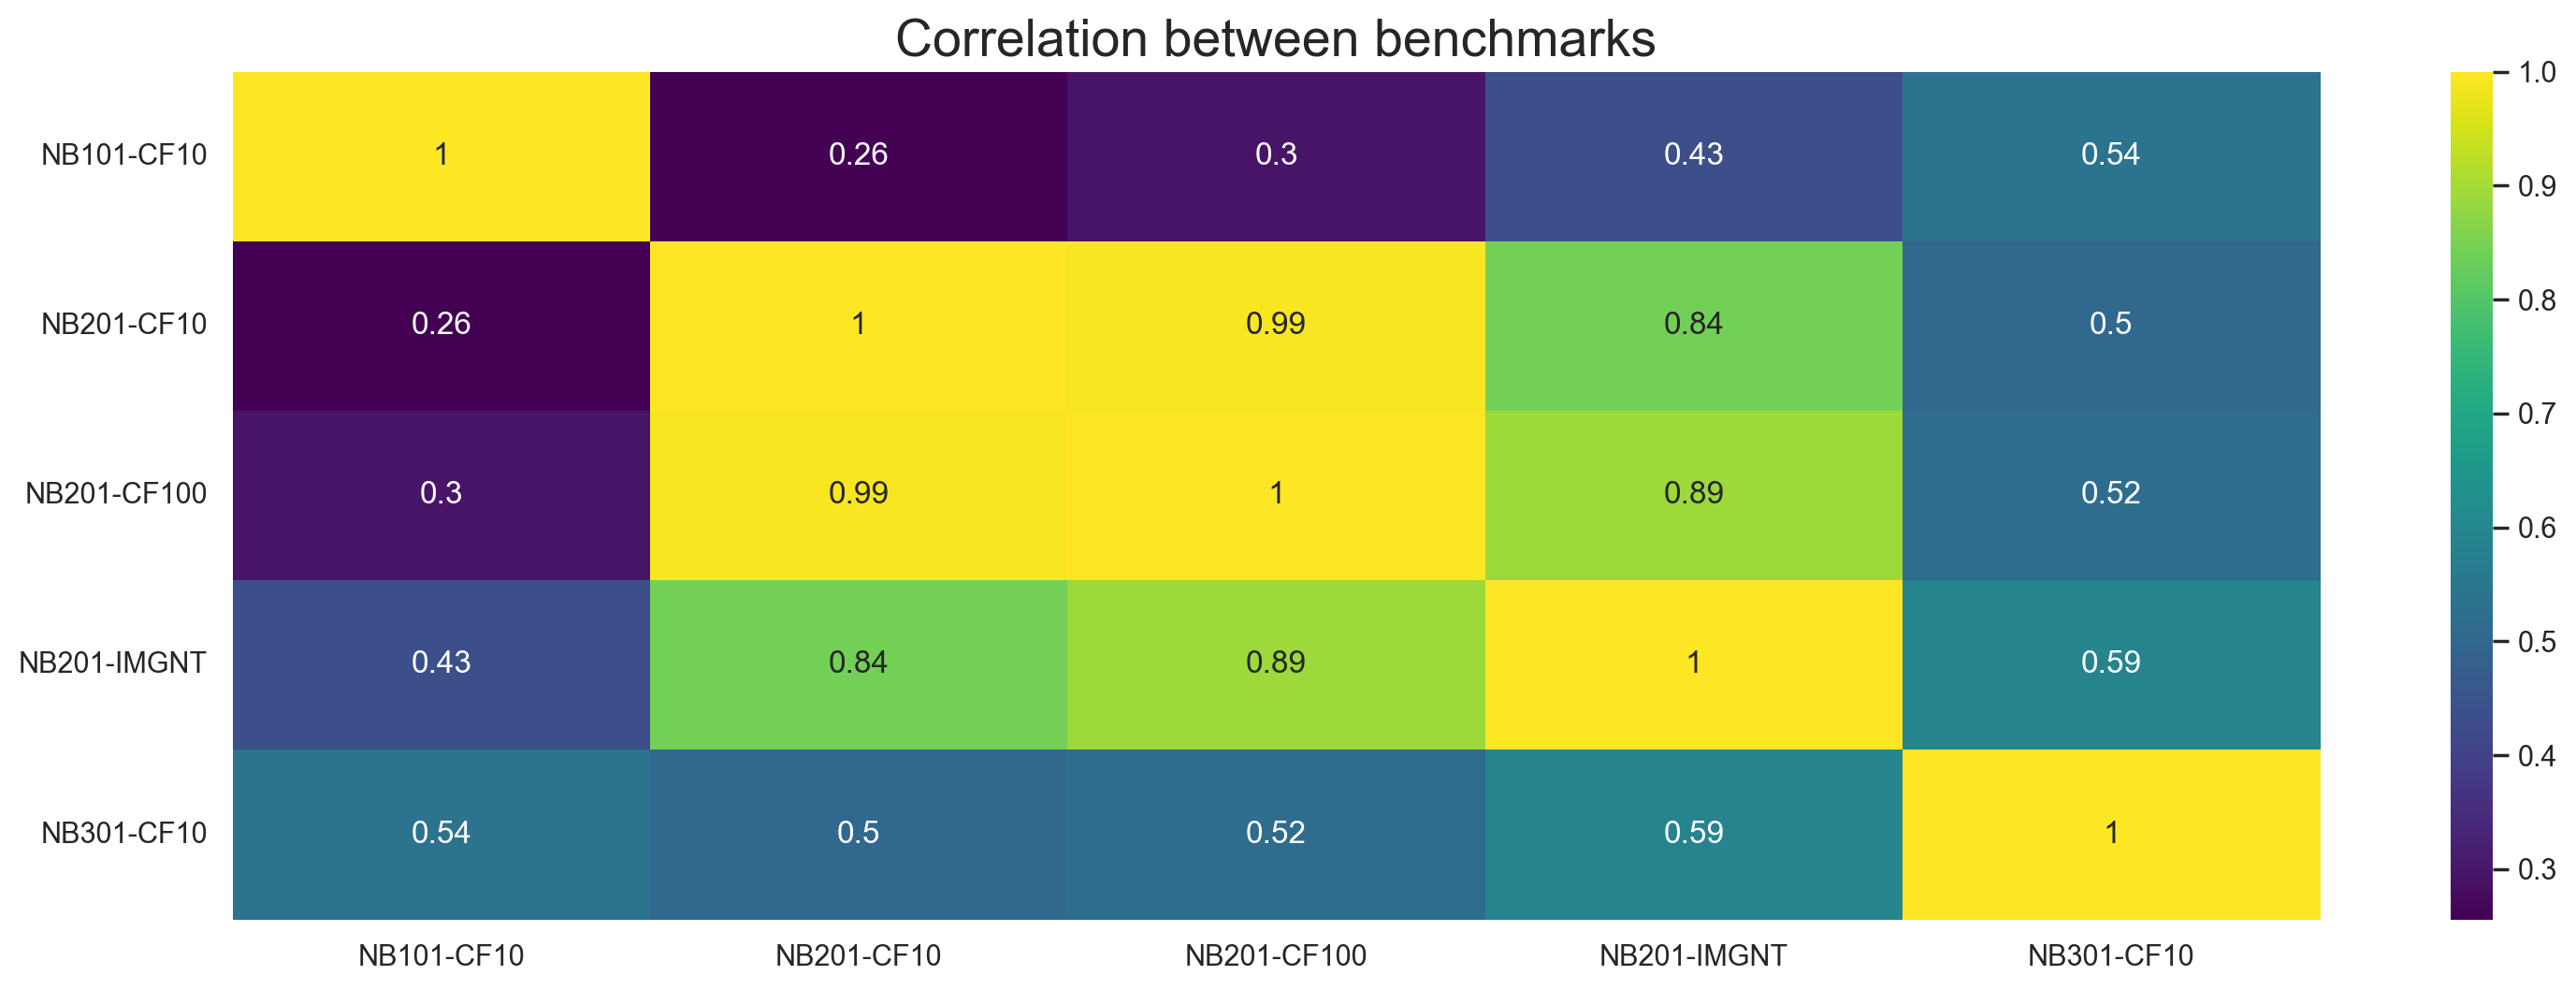

In [6]:
pred_df = make_search_space_predictors_df(df, 'spearman', BENCHMARKS)

plot_heatmap(pred_df, figsize=(18, 6), rotation=0, title='Predictors vs ground truth correlation across benchmarks')
plot_heatmap(pred_df.corr(), figsize=(18, 6), rotation=0, title='Correlation between benchmarks')

# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
pred_df

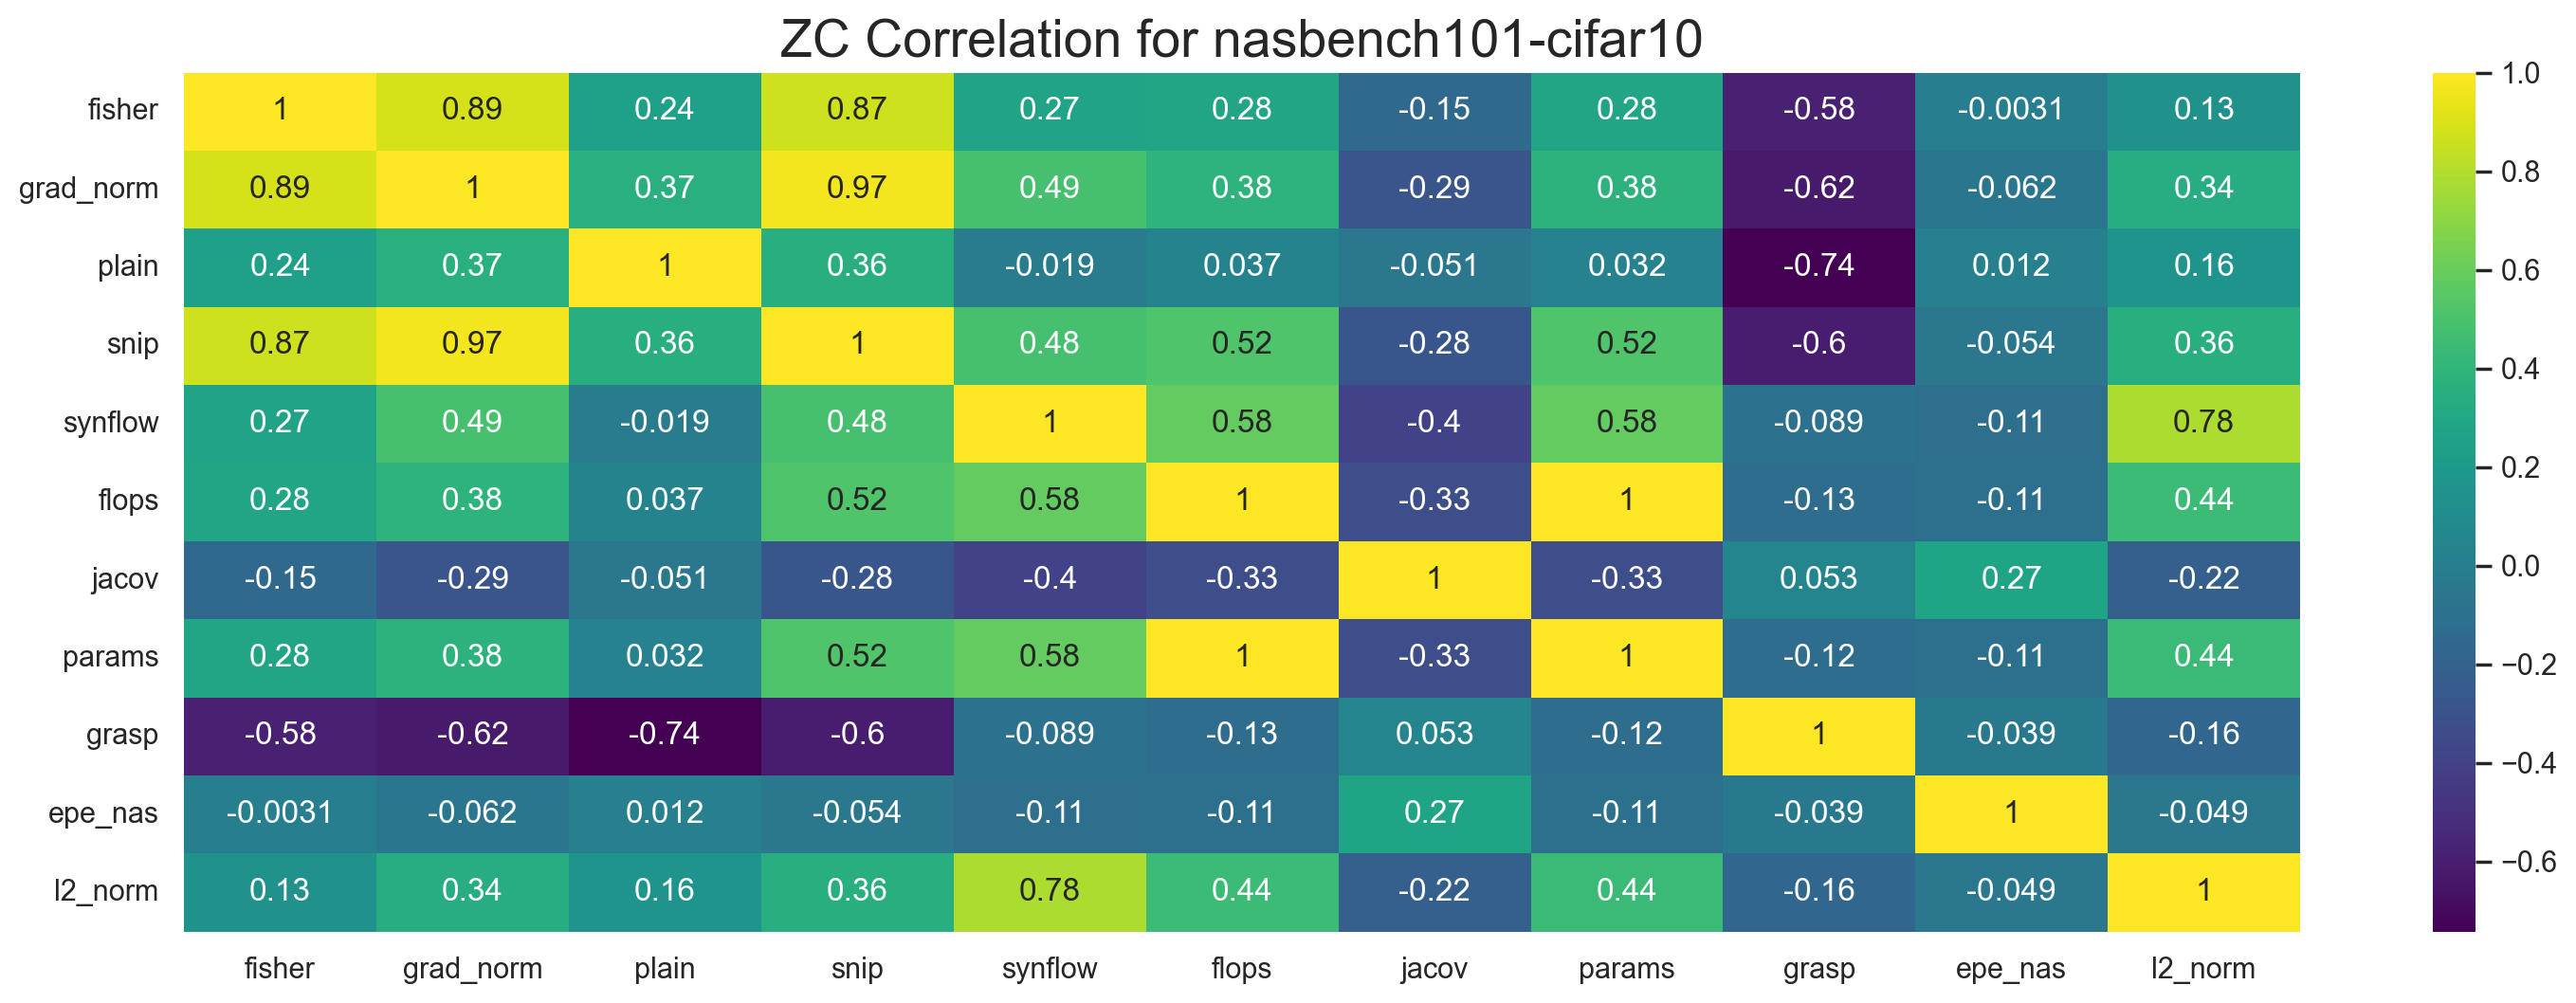

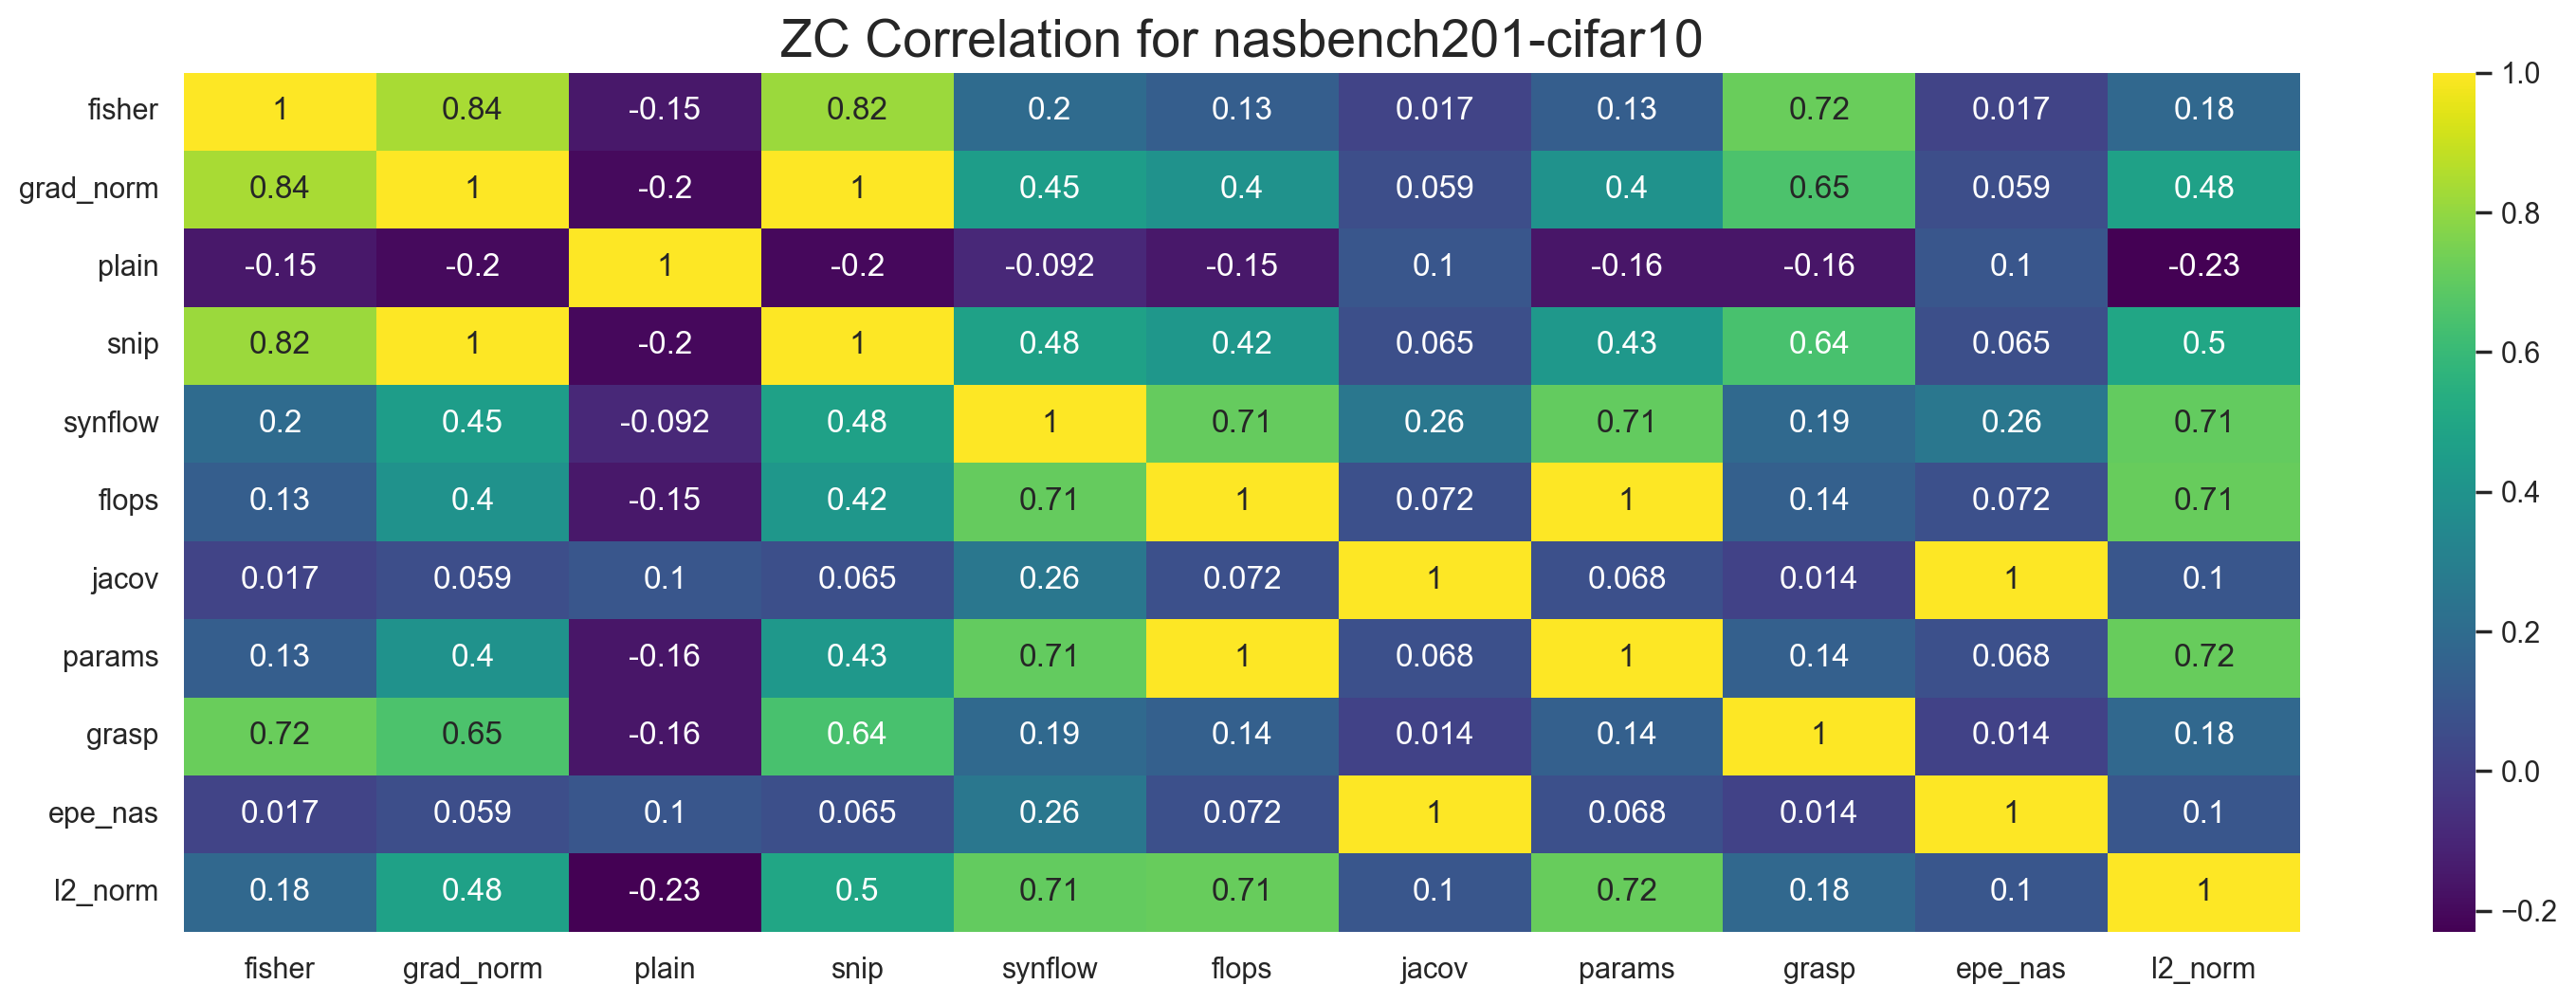

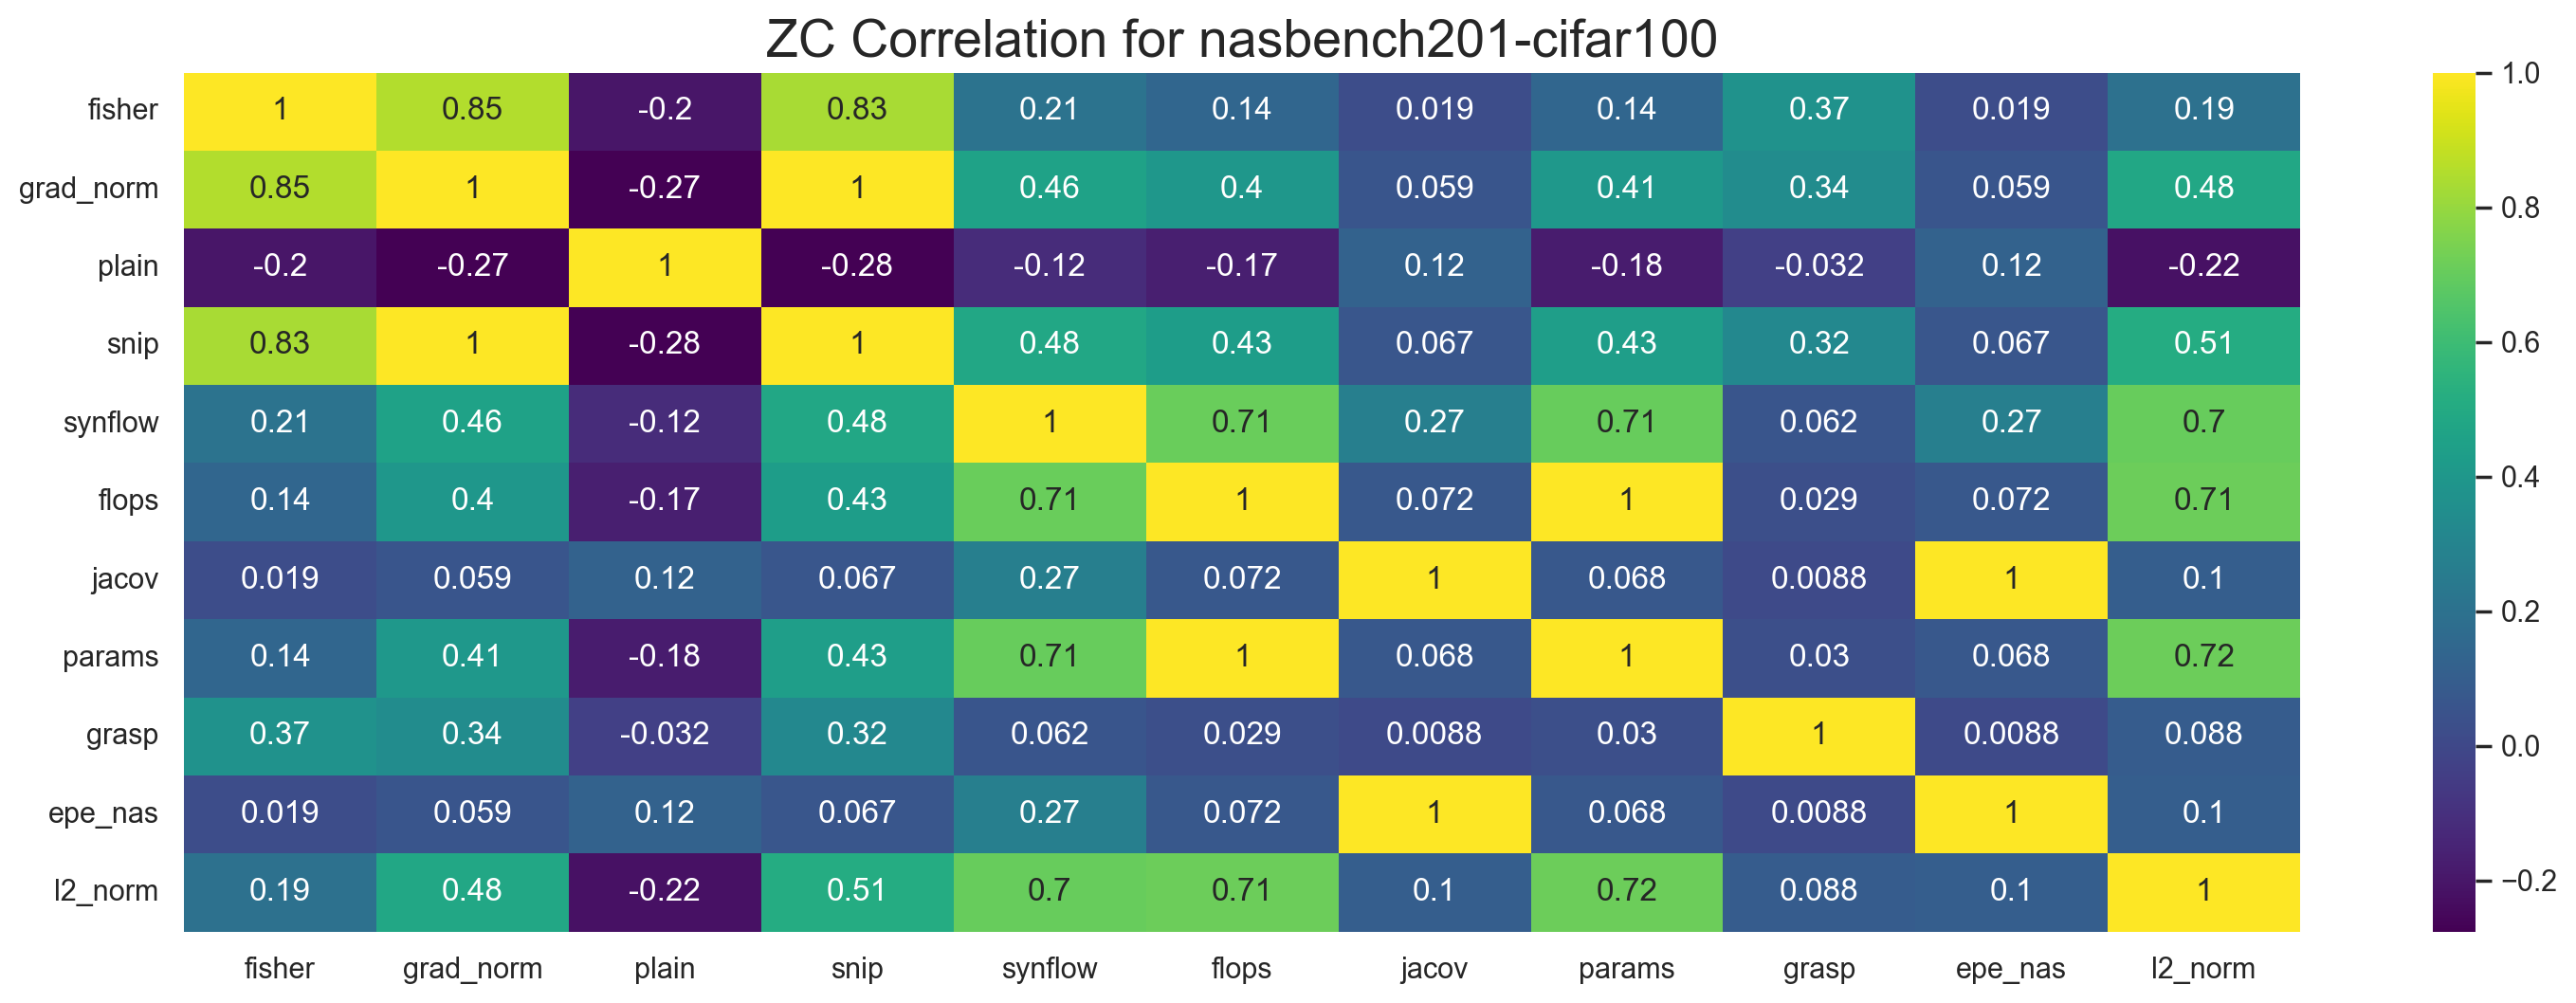

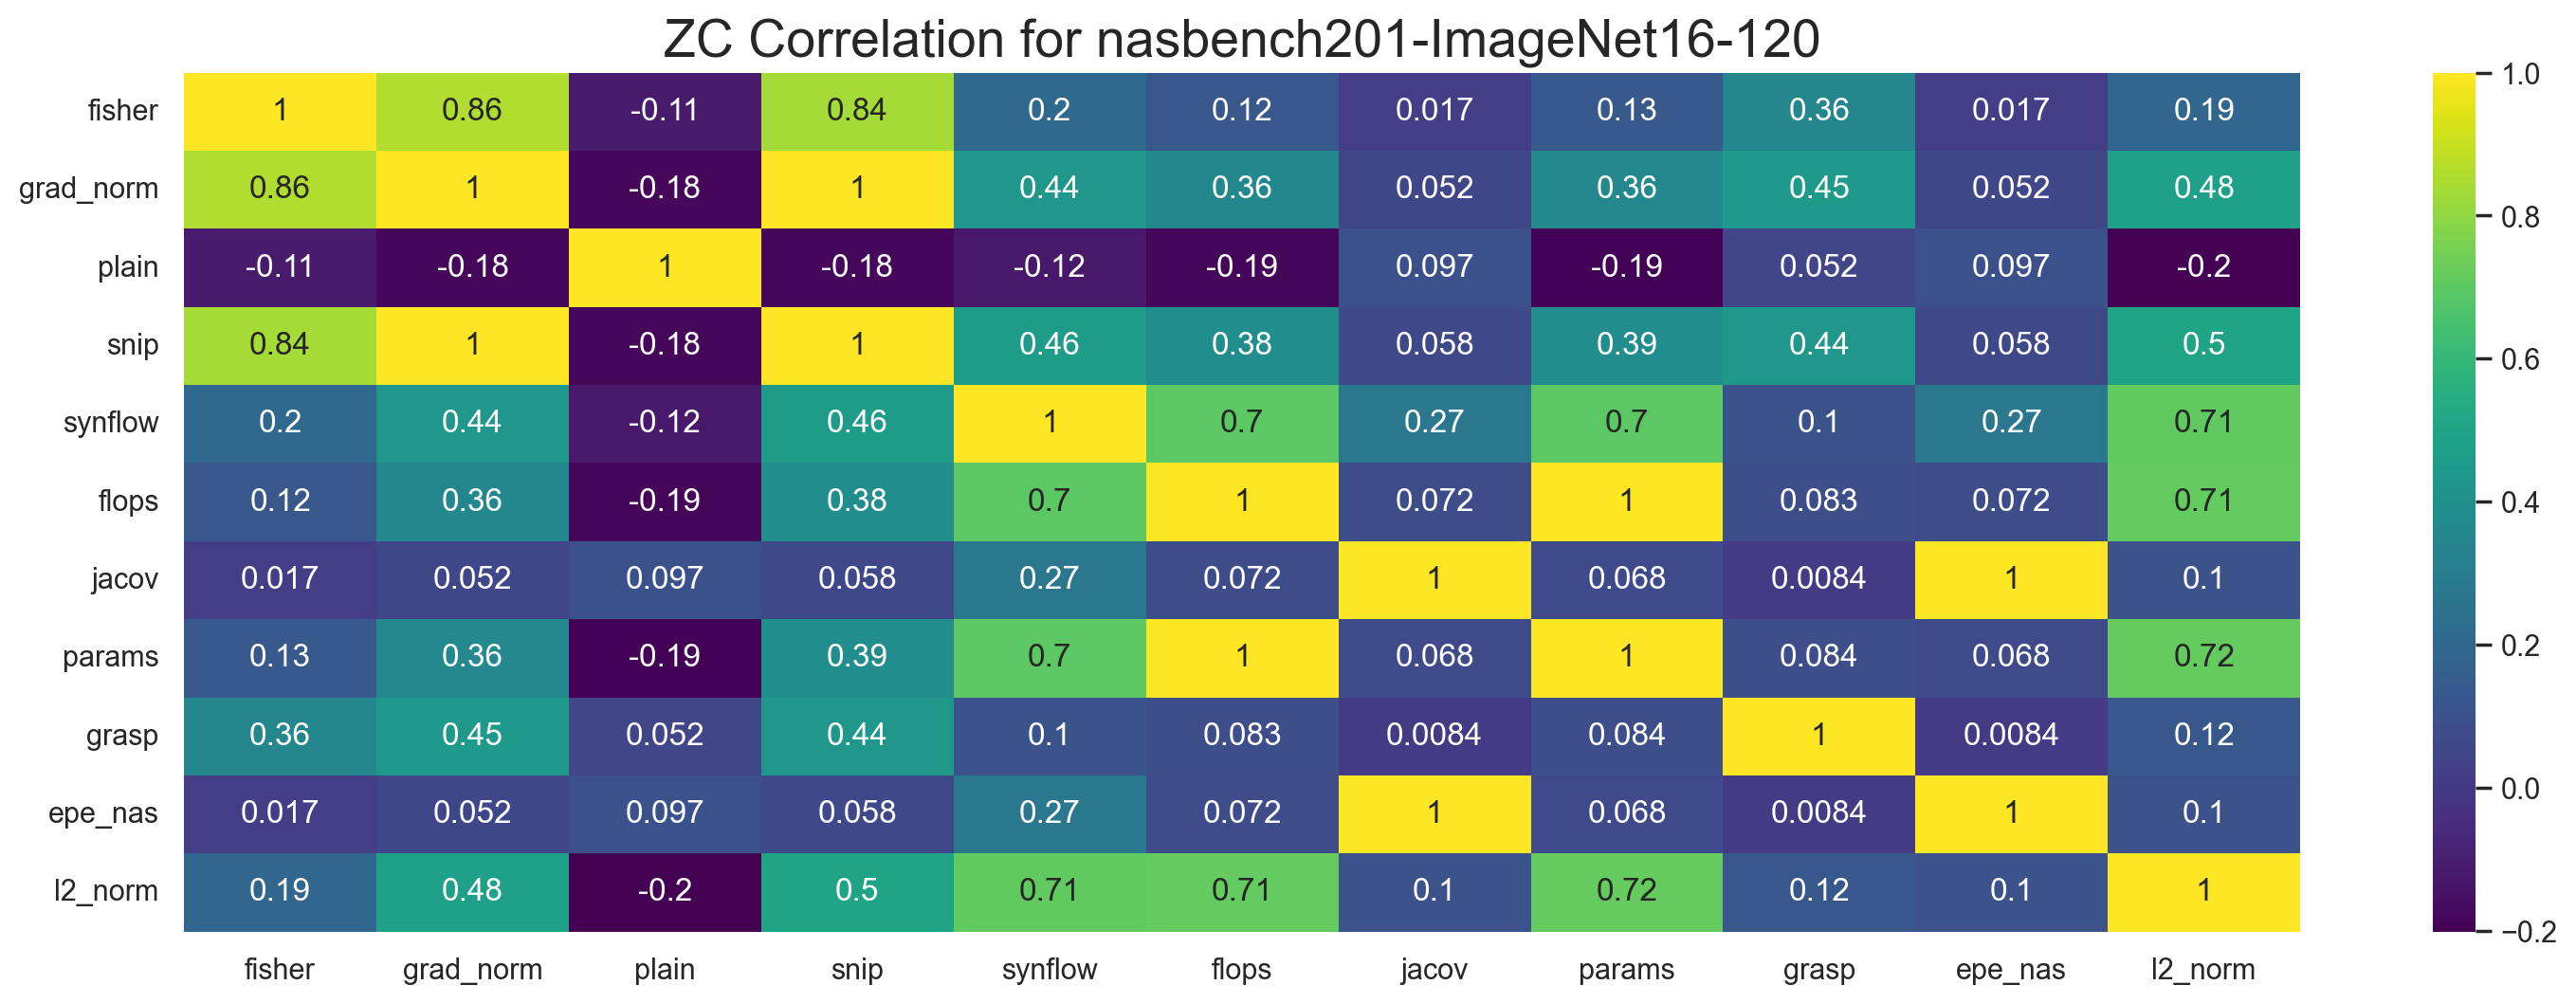

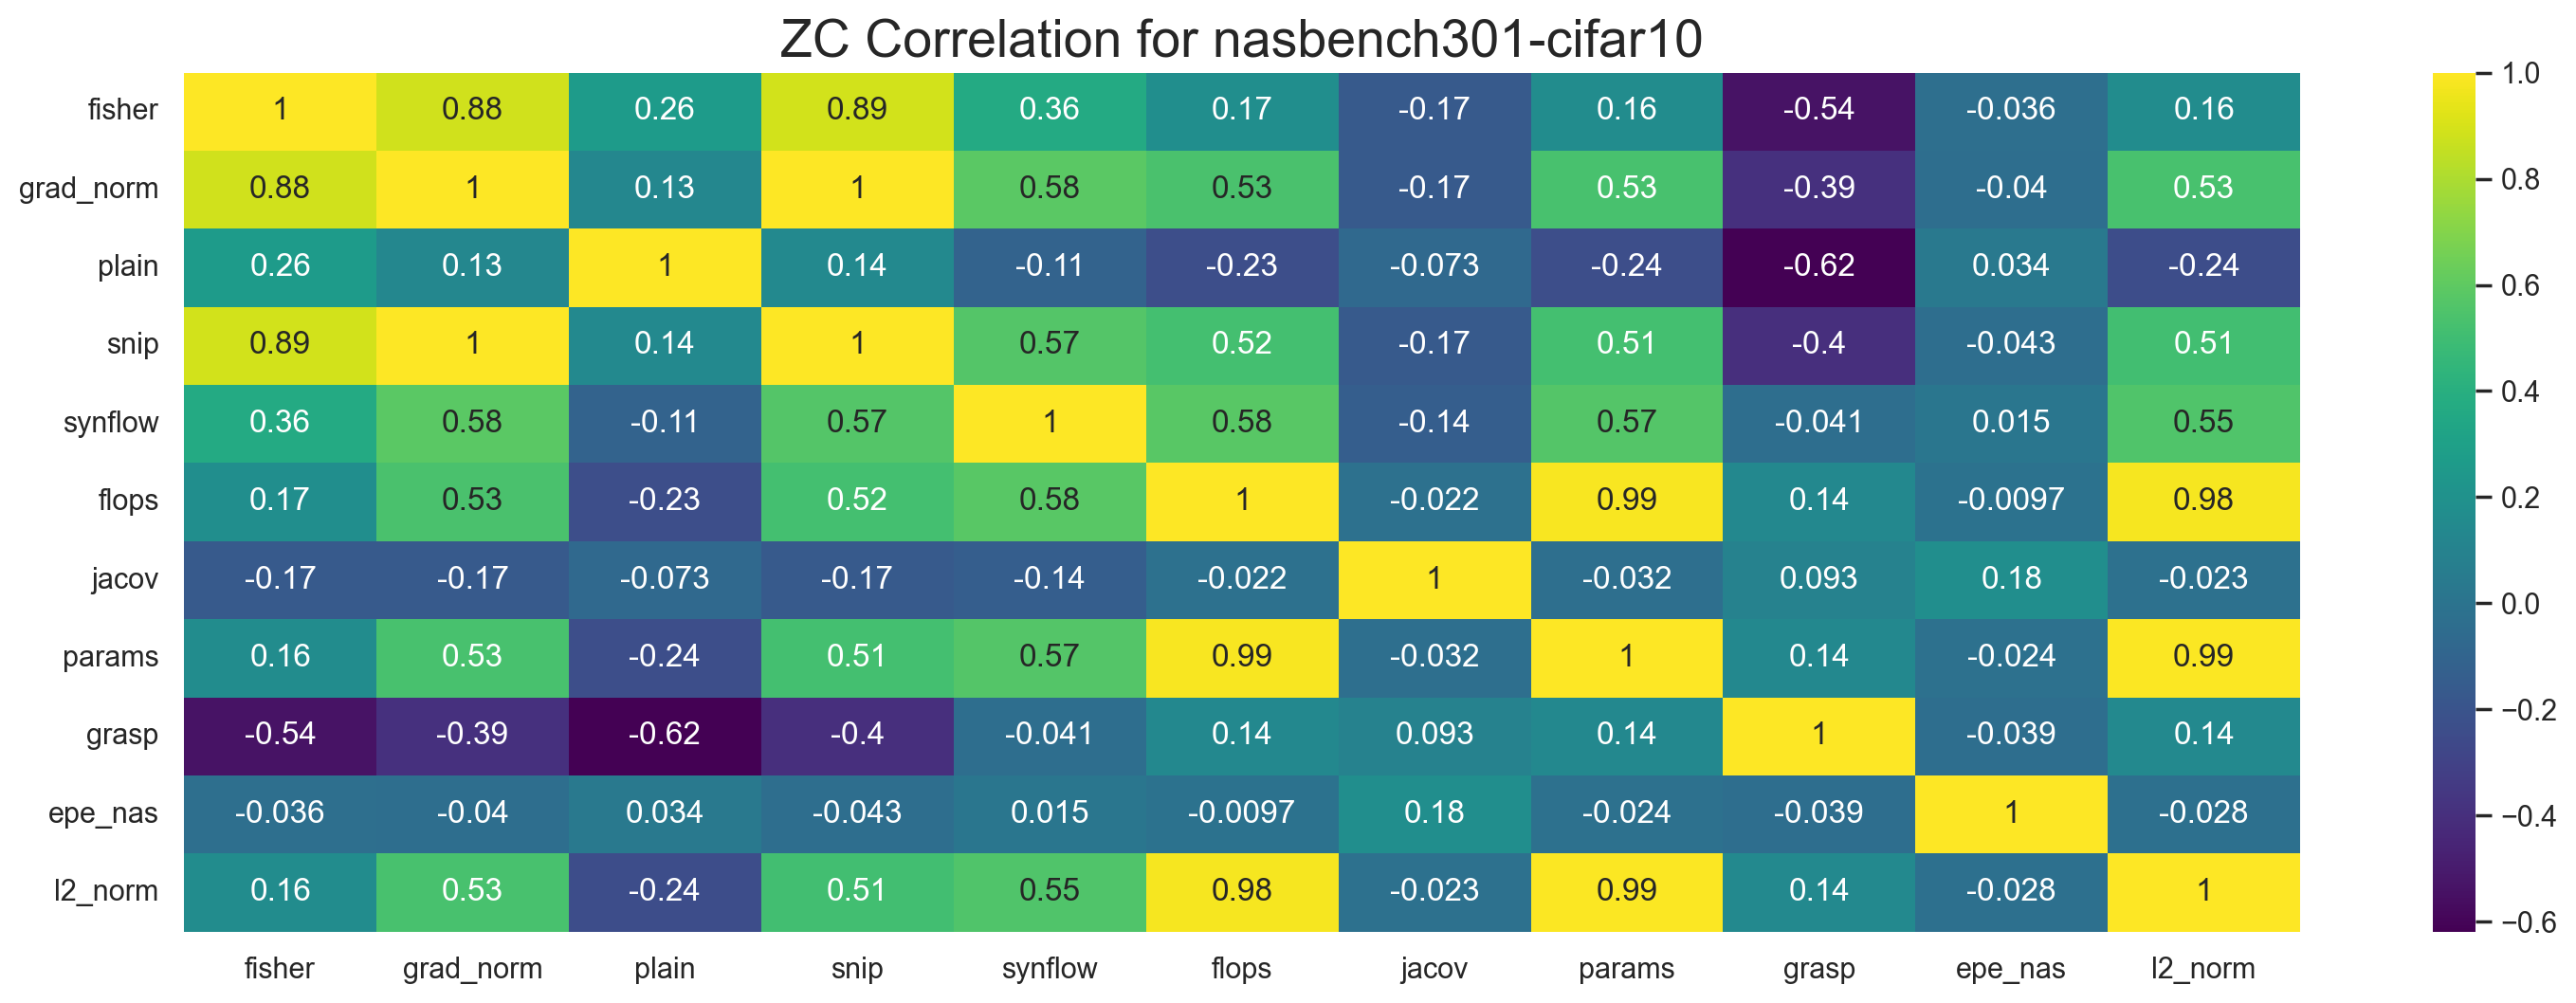

In [7]:
plot_correlation_between_zcs(df, 'nasbench101', 'cifar10')
plot_correlation_between_zcs(df, 'nasbench201', 'cifar10')
plot_correlation_between_zcs(df, 'nasbench201', 'cifar100')
plot_correlation_between_zcs(df, 'nasbench201', 'ImageNet16-120')
plot_correlation_between_zcs(df, 'nasbench301', 'cifar10')
# plot_correlation_between_zcs(df, 'transbench101_micro', 'jigsaw')